Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
#all imports
from __future__ import print_function
import subprocess
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.metrics import confusion_matrix
from six.moves import range
import time
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
#%matplotlib inline

Loading the data and reshape it in a 4 dimension tensor

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save


image_size = 28
num_labels = 10
num_channels = 1 # grayscale

# reformating the dataset to be a 4 dimension tensor
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28, 1) (200000, 10)
Validation: (10000, 28, 28, 1) (10000, 10)
Testing: (10000, 28, 28, 1) (10000, 10)


Data visualization
----

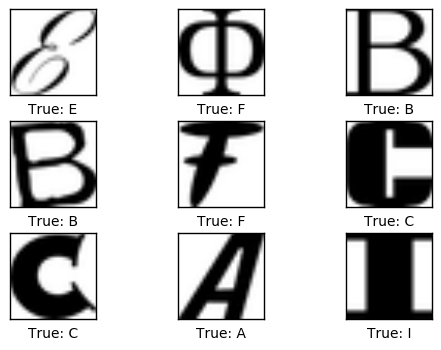

In [3]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

#getting the classes from the one-hot-labels
train_classes = np.argmax(train_labels, axis=1)
train_classes = [chr(i +ord('A')) for i in train_classes]

# the images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Get the first images from the test-set.
images = train_dataset[10:19]

# Get the true classes for those images.
cls_true = train_classes[10:19]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)  

# Number of classes, one class for each of 10 digits.
num_classes = 10

Useful functions
---

In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

#function that performs the weights bias initialization  
def init_weights_biases(shape,weights_name,biases_name):
    layer = {\
        'weights':tf.Variable(tf.truncated_normal(shape, stddev=0.1),name=weights_name),
        'biases':tf.Variable(tf.zeros(shape[-1]),name=biases_name)}
    return layer


#function that performs the Xavier initialization  
def Xa_init_weights_biases(V_shape,weights_name,biases_name):
    layer = {\
        'weights':tf.get_variable(weights_name, shape=V_shape,\
                                  initializer=tf.contrib.layers.xavier_initializer()),
        'biases':tf.Variable(tf.zeros(V_shape[-1]),name=biases_name)}
    return layer

#linear function of layer layer using data as input 
def linear_activation(data,layer):
    return tf.add(tf.matmul(data, layer['weights'], name = 'multiply'),\
      layer['biases'],name ='add')  

#L2 regularization
def L2(beta,layer):
    return tf_beta*tf.nn.l2_loss(layer['weights'])


#funtion that given the dataset shape X and targets shape Y, returns
#two placeholders for the SGD
def init_placeholders(shape_X,shape_Y,name_X,name_Y):
    X = tf.placeholder(tf.float32, shape =shape_X ,name = name_X)
    Y = tf.placeholder(tf.float32, shape=shape_Y, name = name_Y)
    return X,Y

#initialization of a otimizer (SGD) with exponential decay
def sgd_train(error, starter_learning_rate,steps_for_decay,decay_rate):
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(\
                starter_learning_rate,\
                global_step,\
                steps_for_decay,\
                decay_rate, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    return optimizer.minimize(error, global_step=global_step)

Function to creat a convolutional layer with max pooling
-----

In [5]:
def new_conv_layer(input,
                   layer,
                   use_pooling=True):  # Use 2x2 max-pooling.

    weights = layer['weights']
    biases = layer['biases']

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    conv_layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    conv_layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        conv_layer = tf.nn.max_pool(value=conv_layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    conv_layer = tf.nn.relu(conv_layer)
    
    return conv_layer

This is the model: 
---
2 convolutional layers and 4 connected layers


In [12]:
def network(\
            data,\
            V_hidden_layer_1,\
            V_hidden_layer_2,\
            V_hidden_layer_3,\
            V_hidden_layer_4,\
            V_hidden_layer_5,\
            V_hidden_layer_6):
    with tf.name_scope('Convolution_1'):
        conv_layer1 = new_conv_layer(data,V_hidden_layer_1,use_pooling=True)
    with tf.name_scope('Convolution_2'):
        conv_layer2 = new_conv_layer(conv_layer1,V_hidden_layer_2,use_pooling=True)
    with tf.name_scope('Reshape'):
        shape = conv_layer2.get_shape().as_list() 
        reshape = tf.reshape(conv_layer2, [shape[0], shape[1] * shape[2] * shape[3]])
    with tf.name_scope('Hidden_Layer_1'):
        hidden_la1 = tf.nn.relu(linear_activation(reshape,V_hidden_layer_3)) 
    with tf.name_scope('Hidden_Layer_2'):
        hidden_la2 = tf.sigmoid(linear_activation(hidden_la1,V_hidden_layer_4))
    with tf.name_scope('Hidden_Layer_3'):
        hidden_la3 = tf.sigmoid(linear_activation(hidden_la2,V_hidden_layer_5))     
    with tf.name_scope('Output_Layer'):
        logits = linear_activation(hidden_la3,V_hidden_layer_6) 
    return logits

Tensorflow graph
----

In [17]:
batch_size = 128
patch_size = 6
filters_1 = 16
filters_2 = 32
hidden_nodes_1 = 60
hidden_nodes_2 = 40
hidden_nodes_3 = 20


graph = tf.Graph() 
with graph.as_default():
    
    #Placeholders for the SGD.
    tf_train_dataset, tf_train_labels  = init_placeholders(\
                                            (batch_size, image_size,image_size, num_channels),\
                                            (batch_size, num_labels),'X','Y')

    #constants: we use then to see accuracity of the network
    tf_valid_dataset = tf.constant(valid_dataset, name ='X_va')
    tf_test_dataset = tf.constant(test_dataset, name ='X_test')

    #constant for the L2 regularization 
    tf_beta = tf.constant(0.005)
    
      
    #hidden layer 1 - normal initialization 
    tf_hidden_layer_1 = init_weights_biases(\
                    [patch_size, patch_size, num_channels, filters_1],
                    "weights1",'biases1')

    #hidden layer 2 - normal initialization 
    tf_hidden_layer_2 = init_weights_biases(\
                [patch_size, patch_size, filters_1, filters_2],
                "weights2",'biases2')
    
    #hidden layer 3 - Xavier initialization
    tf_hidden_layer_3 = init_weights_biases(\
                    [image_size // 4 * image_size // 4 * filters_2, hidden_nodes_1],
                    "weights3",'biases3')


    #hidden layer 4 - Xavier initialization 
    tf_hidden_layer_4 = init_weights_biases(\
                [hidden_nodes_1, hidden_nodes_2],
                "weights4",'biases4')
    
    #hidden layer 5 - normal initialization 
    tf_hidden_layer_5 = init_weights_biases(\
                [hidden_nodes_2, hidden_nodes_3],
                "weights5",'biases5')
    
    
    #hidden layer 6 - normal initialization 
    tf_hidden_layer_6 = init_weights_biases(\
                [hidden_nodes_3, num_labels],
                "weights6",'biases6')  
    
    #histogram summaries for weights
    tf.histogram_summary('weights1_summ',tf_hidden_layer_1['weights'])
    tf.histogram_summary('weights2_summ',tf_hidden_layer_2['weights'])
    tf.histogram_summary('weights3_summ',tf_hidden_layer_3['weights'])
    tf.histogram_summary('weights4_summ',tf_hidden_layer_4['weights'])
    tf.histogram_summary('weights5_summ',tf_hidden_layer_5['weights'])
    tf.histogram_summary('weights6_summ',tf_hidden_layer_6['weights'])
        
    #the NN with the train dataset
    logits = network(\
                     tf_train_dataset,\
                     tf_hidden_layer_1,\
                     tf_hidden_layer_2,\
                     tf_hidden_layer_3,\
                     tf_hidden_layer_4,\
                     tf_hidden_layer_5,\
                     tf_hidden_layer_6)

    #the NN with the valid dataset
    valid_network = network(\
                    tf_valid_dataset,\
                    tf_hidden_layer_1,\
                    tf_hidden_layer_2,\
                    tf_hidden_layer_3,\
                    tf_hidden_layer_4,\
                    tf_hidden_layer_5,\
                    tf_hidden_layer_6)
    
    #the NN with the test dataset
    test_network = network(\
                    tf_test_dataset,\
                    tf_hidden_layer_1,\
                    tf_hidden_layer_2,\
                    tf_hidden_layer_3,\
                    tf_hidden_layer_4,\
                    tf_hidden_layer_5,\
                    tf_hidden_layer_6)

    with tf.name_scope('loss'):
      loss = tf.reduce_mean(\
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))\
        #+ L2(tf_beta,tf_hidden_layer_1)\
        #+ L2(tf_beta,tf_hidden_layer_2)\
        #+ L2(tf_beta,tf_hidden_layer_3)\
        #+ L2(tf_beta,tf_hidden_layer_4)
      tf.scalar_summary(loss.op.name,loss) #write loss to log

    #Optimizer.
    with tf.name_scope('training'):
        optimizer = sgd_train(loss, 0.9,100,0.96)    
    #with tf.name_scope('training'):
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    #applying the softmax function on the 
    #network with the train, valid,
    #and test datasets, respectively.       
    train_prediction = tf.nn.softmax(logits, name='train_network')
    train_pred_cls = tf.argmax(train_prediction, dimension=1)
    valid_prediction = tf.nn.softmax(valid_network, name='valid_network')
    test_prediction = tf.nn.softmax(test_network, name='test_network')

    #Minibatch accuracy
    with tf.name_scope('accuracy'):
        correct_pred = tf.equal(tf.argmax(train_prediction, 1), tf.argmax(tf_train_labels, 1))
        acc_op = tf.reduce_mean(tf.cast(correct_pred,'float'))
        tf.scalar_summary(acc_op.op.name,acc_op) #write acc to log


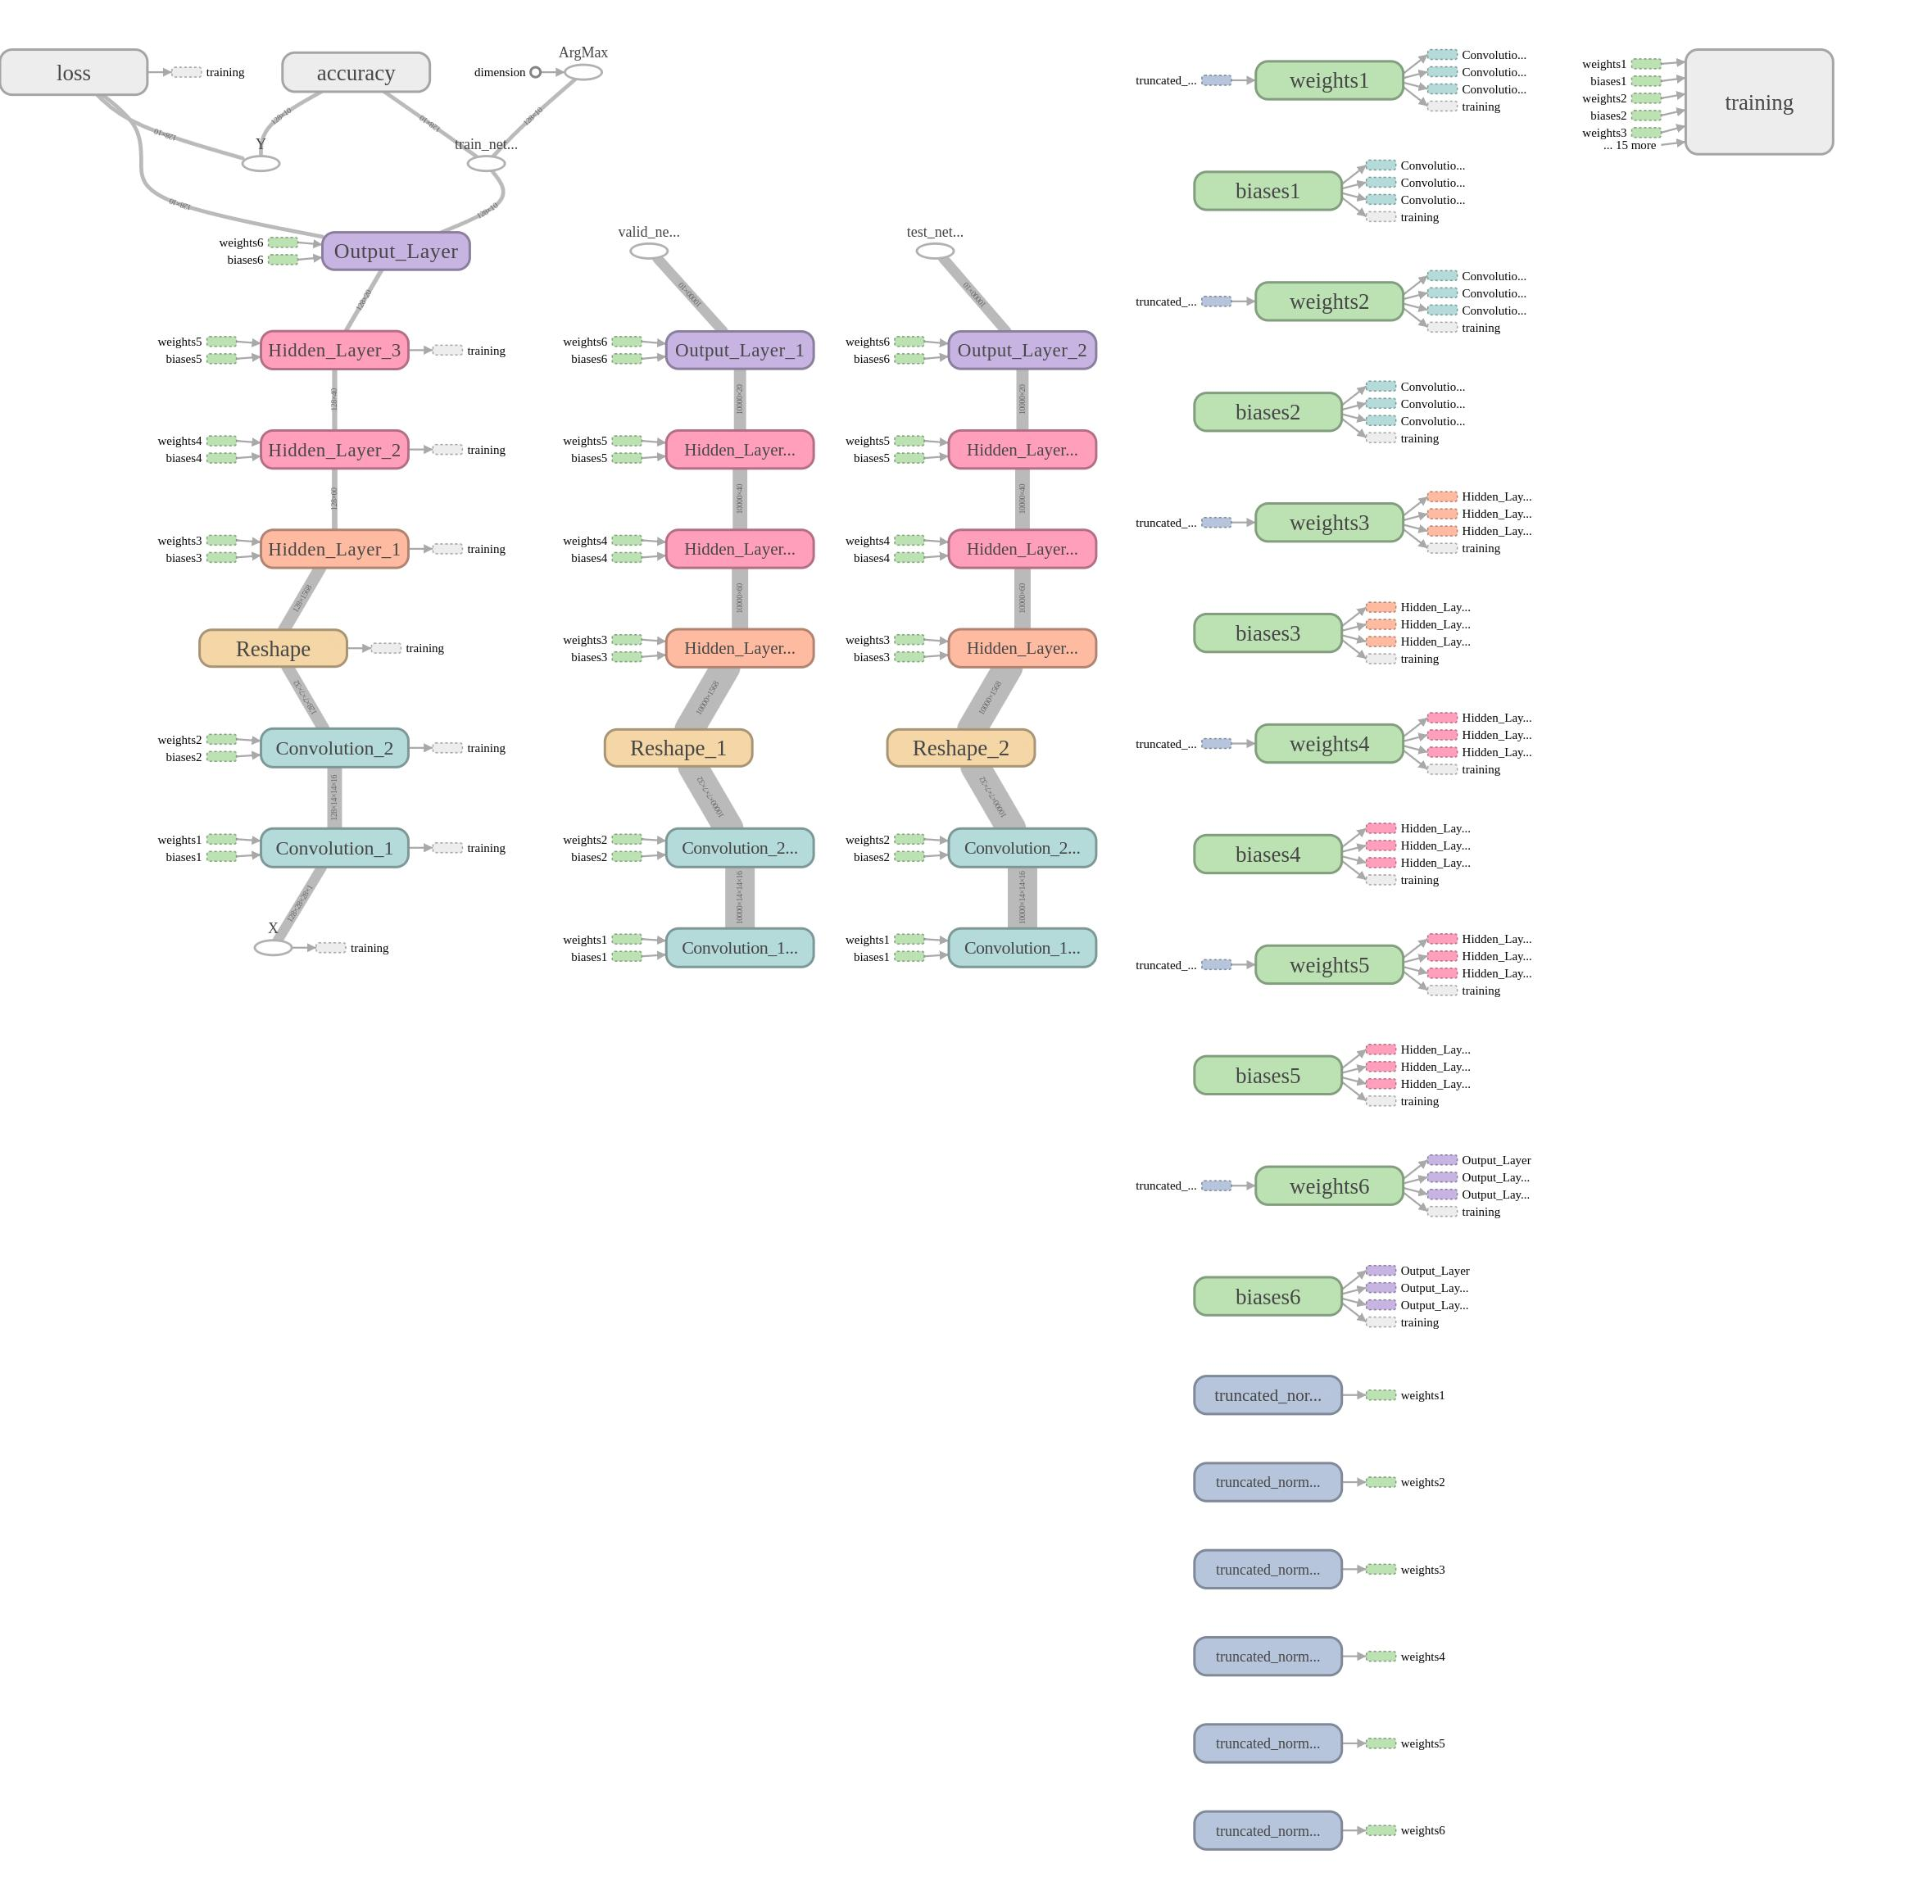

In [16]:
#here is a visualization in tensorboard
from IPython.display import Image
Image(filename="graph.jpeg") 

Running Session
----

In [8]:
#direction for the writer to log
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)

num_steps = 10001

initial_time = time.time()

with tf.Session(graph=graph) as session:
  summary_writer = tf.train.SummaryWriter(log_path, session.graph) 
  all_summaries = tf.merge_all_summaries() 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
   
    # Pick an offset within the training data, which has been randomized.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Prepare a dictionary telling the session where to feed the minibatch.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    #we are going to run the session and count the duration of the running
    start_time = time.time()
    _, l, predictions, acc, summary = session.run(
      [optimizer, loss, train_prediction, acc_op, all_summaries], feed_dict=feed_dict)
    duration = time.time() - start_time
    
    #writing the log
    summary_writer.add_summary(summary,step)
    summary_writer.flush()
    
    #Printing an overwiew
    if (step % 1000 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.2f%%" % (acc*100))
        print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
        print('Duration: %.3f sec' % duration)
        #print_test_accuracy()
        
  #after the loop compair our model with the test dataset    
  print("Test accuracy: %.1f%%" % \
    accuracy(test_prediction.eval(), test_labels))


#subprocess.call(['speech-dispatcher'])        
#subprocess.call(['spd-say', '"over"'])
general_duration = time.time() - initial_time
sec = timedelta(seconds=int(general_duration))
d_time = datetime(1,1,1) + sec
print(' ')
print('The duration of the whole training with % s steps is %.2f seconds,'\
      % (num_steps,general_duration))
print("which is equal to:  %d:%d:%d:%d" % (d_time.day-1, d_time.hour, d_time.minute, d_time.second), end='')
print(" (DAYS:HOURS:MIN:SEC)")
print(' ')
print(log_path)
#!tensorboard --logdir=!!!copy log_path here!!!

Initialized
Minibatch loss at step 0: 2.335468
Minibatch accuracy: 7.81%
Validation accuracy: 10.0%
Duration: 0.172 sec
Minibatch loss at step 1000: 0.355184
Minibatch accuracy: 90.62%
Validation accuracy: 88.8%
Duration: 0.100 sec
Minibatch loss at step 2000: 0.259612
Minibatch accuracy: 92.19%
Validation accuracy: 89.9%
Duration: 0.107 sec
Minibatch loss at step 3000: 0.276818
Minibatch accuracy: 89.84%
Validation accuracy: 90.7%
Duration: 0.115 sec
Minibatch loss at step 4000: 0.253304
Minibatch accuracy: 91.41%
Validation accuracy: 90.8%
Duration: 0.101 sec
Minibatch loss at step 5000: 0.250106
Minibatch accuracy: 92.19%
Validation accuracy: 91.0%
Duration: 0.099 sec
Minibatch loss at step 6000: 0.210405
Minibatch accuracy: 95.31%
Validation accuracy: 91.3%
Duration: 0.097 sec
Minibatch loss at step 7000: 0.314100
Minibatch accuracy: 91.41%
Validation accuracy: 91.4%
Duration: 0.099 sec
Minibatch loss at step 8000: 0.165724
Minibatch accuracy: 94.53%
Validation accuracy: 91.3%
Dura

In [1]:
#!tensorboard --logdir=logs/15-11-2016_20-06-50

In [2]:
#Com os valores 

#batch_size = 128
#patch_size = 6
#filters_1 = 16
#filters_2 = 32
#hidden_nodes_1 = 4000
#hidden_nodes_2 = 2000
#hidden_nodes_3 = 1000

#obtive apenas -> Test accuracy: 96.9%